In [1]:
import numpy as np
import matplotlib.pyplot as plt
from methods import *
from scipy.integrate import RK23, RK45

a) Legendre Tau Method and Legendre Collocation Method

Text(0, 0.5, 'Relative error')

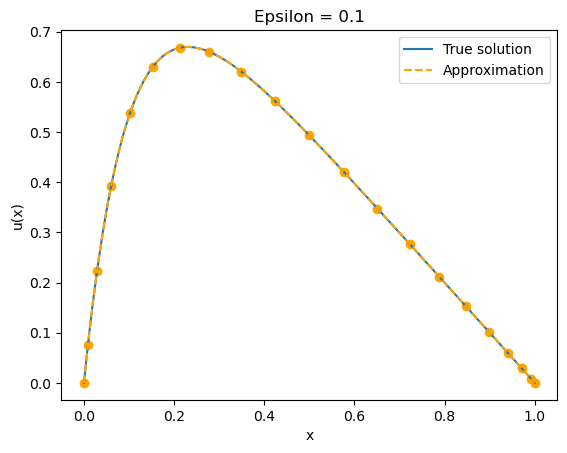

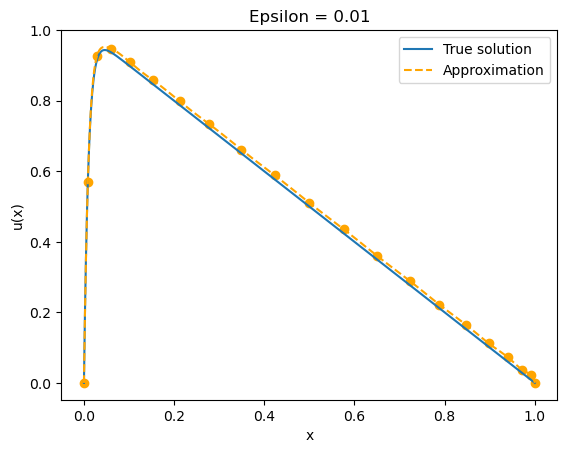

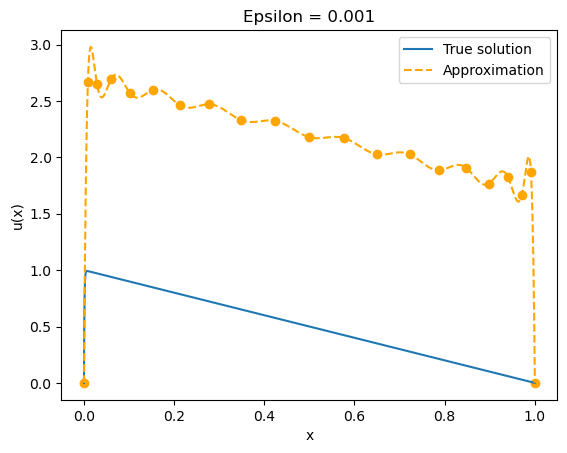

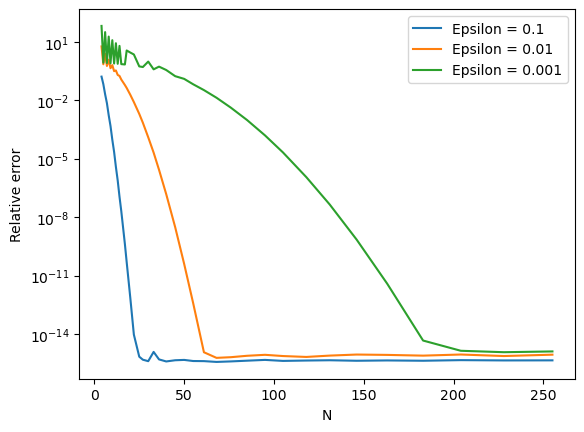

In [789]:
def true_u(x,eps):
    return (np.exp(-x/eps)+(x-1)-np.exp(-1/eps)*x)/(np.exp(-1/eps)-1)
true_u = np.vectorize(true_u)

plot_approximations = True
method = "LTM" # LCM or LTM
epsilons = [0.1,0.01,0.001]
Ns = np.ceil(np.logspace(0,2.4,50))+3
rel_err = []

for eps in epsilons:
    for N in Ns:
        N = int(N)
        xGL = JacobiGL(0,0,N)
        ys = (xGL+1)/2
        if method == "LCM":
            D = Dmatrix_Legendre(N,xGL,0,1)
            LN = -eps*D@D-D
            LN[0,:] = np.concatenate(([1],np.zeros(N)))
            LN[-1,:] = np.concatenate((np.zeros(N),[1]))
            f_tilde = np.concatenate(([0],np.ones(N-1),[0]))
            u_hat = np.linalg.solve(LN,f_tilde)
            rel_err.append(np.linalg.norm(u_hat-true_u(ys,eps))/(np.linalg.norm(true_u(ys,eps))))
        elif method == "LTM":
            u_hat = LTM_2ord(xGL, N, -eps*4, -2, None)
            rel_err.append(np.linalg.norm(u_hat-true_u(ys,eps))/(np.linalg.norm(true_u(ys,eps))))
        if N == 20 and plot_approximations:
            plt.figure()
            XX = JacobiGL(0,0,500)
            if method == "LTM":
                plt.plot(ys,u_hat,'o',color="orange")
                u_hat = LTM_2ord(XX, N, -eps*4, -2, None) # approximate in between nodes
                YY = (XX+1)/2
                plt.plot(YY,true_u(YY,eps), label="True solution")
                plt.plot(YY,u_hat,'--',color="orange",label="Approximation")
            else:
                fine_grid = (XX+1)/2
                plt.plot(fine_grid,true_u(fine_grid,eps), label="True solution")
                plt.plot(ys,u_hat,'o',label="Approximation")
            plt.xlabel("x")
            plt.ylabel("u(x)")
            plt.title(f"Epsilon = {eps}")
            plt.legend()
            
plt.figure()
plt.semilogy(Ns,rel_err[0:len(Ns)],label=f"Epsilon = {epsilons[0]}")
plt.semilogy(Ns,rel_err[len(Ns):2*len(Ns)],label=f"Epsilon = {epsilons[1]}")
plt.semilogy(Ns,rel_err[2*len(Ns):(3*len(Ns))],label=f"Epsilon = {epsilons[2]}")
plt.legend()
plt.xlabel("N")
plt.ylabel("Relative error")

b) 2D BVP

Text(0, 0.5, 'Relative error')

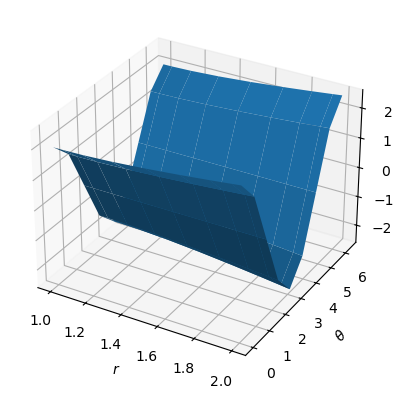

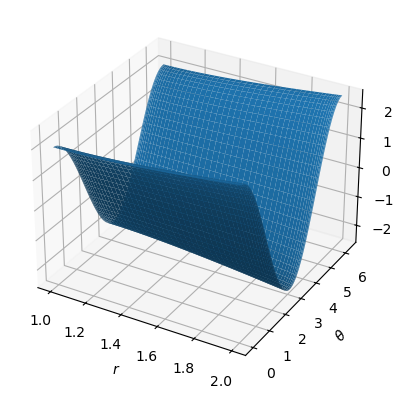

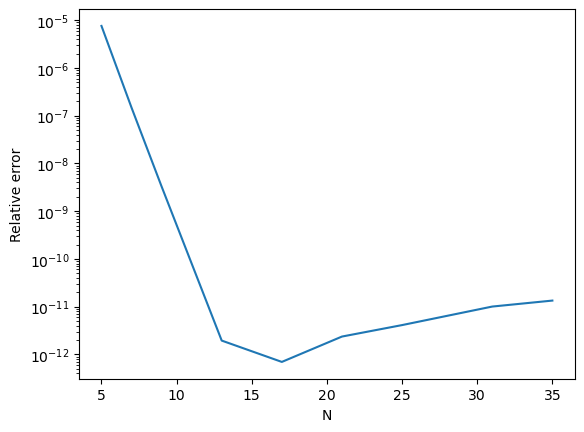

In [73]:
def true_phi(r,theta):
    return (r+1/r)*np.cos(theta)

plot_2d_approximations = True
rel_errors = []
Ns = np.array([4,6,8,12,16,20,24,30,34])
Ns = Ns+1 # Need uneven for our current Fourier matrix to work
for N in Ns:
    
    ### r - direction
    x_r = JacobiGL(0,0,N-1)
    X_r = (x_r+3)/2
    D_r = Dmatrix_Legendre(N-1,x_r,1,2)

    ### theta - direction
    x_theta = [2*np.pi*j/(N-1) for j in range(N-1)] 
    X_theta = np.concatenate([x_theta,[2*np.pi]]) # Include boundary point
    D_theta = Dmatrix_Fourier(N-1,x_theta)
    D_theta = np.vstack([D_theta,D_theta[0]])
    D_theta = np.c_[D_theta,np.zeros(N)] # again to include boundary point

    ### 2D matrices
    Dtheta_2d = np.kron(D_theta,np.identity(N))
    Dr_2d = np.kron(np.identity(N),D_r)
    I_r = np.kron(np.identity(N),np.diag(1/X_r))
    LN = I_r@Dr_2d + Dr_2d@Dr_2d + I_r@I_r@Dtheta_2d@Dtheta_2d
    RHS = np.zeros(N**2)
    
    ### Boundary conditions
    for i in range(N):
        index = N*i
        b1 = np.zeros(N**2)
        b1[index] = 1
        LN[index,:] = b1
        RHS[index] = 2*np.cos(X_theta[i])
        ##
        index = (N-1) + N*i
        b1 = np.zeros(N**2)
        b1[index] = 1
        LN[index,:] = b1
        RHS[index] = 2.5*np.cos(X_theta[i])
        ##
        index = i
        b1 = np.zeros(N**2)
        b1[index] = 1
        LN[index,:] = b1
        RHS[index] = X_r[i]+1/X_r[i]
        ##
        index = (N-1)*N + i
        b1 = np.zeros(N**2)
        b1[index] = 1
        LN[index,:] = b1
        RHS[index] = X_r[i]+1/X_r[i]

    u_hat = np.linalg.solve(LN,RHS)
    r,theta = np.meshgrid(X_r, X_theta)
    true_sol = true_phi(r,theta)
    u_hat = u_hat.reshape((N,N))
    rel_errors.append(np.linalg.norm(true_sol - u_hat)/np.linalg.norm(true_sol))
    if N == 9 and plot_2d_approximations:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.plot_surface(r,theta,u_hat)
        ax.set_xlabel(r'$r$')
        ax.set_ylabel(r'$\theta$')
        N_fine = 50
        x_r = JacobiGL(0,0,N_fine-1) 
        X_r = (x_r+3)/2
        x_theta = [2*np.pi*j/(N_fine-1) for j in range(N_fine-1)] 
        X_theta = np.concatenate([x_theta,[2*np.pi]])
        r,theta = np.meshgrid(X_r, X_theta)
        # x,y = np.meshgrid(np.cos(X_theta)*X_r, np.sin(X_theta)*X_r)
        true_sol = true_phi(r,theta)
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.plot_surface(r,theta,true_sol)
        ax.set_xlabel(r'$r$')
        ax.set_ylabel(r'$\theta$')
        
        
    
plt.figure()
plt.semilogy(Ns,rel_errors)
plt.xlabel("N")
plt.ylabel("Relative error")

Part 2 c)-e) IVP

Max time step used in RK3: 0.00019535759096612294


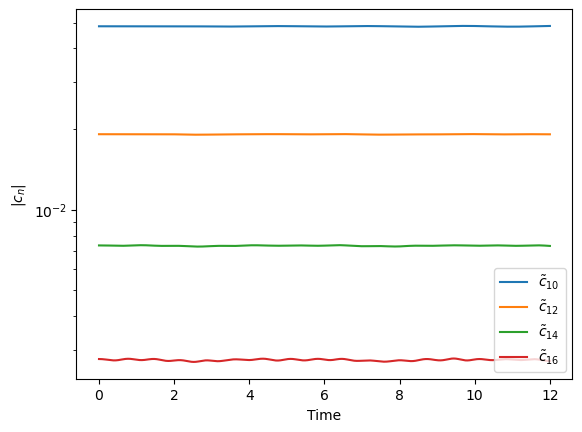

In [786]:
import numpy as np
import matplotlib.pyplot as plt
from methods import *
from scipy.integrate import RK23, RK45, solve_ivp

import warnings
warnings.filterwarnings('ignore')

def tran(x): # transform coordinates
    return None

def sech_squared(x):
    return (2*np.exp(x)/(np.exp(2*x)+1))**2

def true_u(x,t,c,x0):
    return 1/2*c*sech_squared(1/2*np.sqrt(c)*(x-c*t-x0))
true_u = np.vectorize(true_u)

def Dealias_orzag(u, v):
    uhat = np.fft.fft(u)
    vhat = np.fft.fft(v)
    N = len(uhat)
    M = int(np.ceil(3/2*N))
    uhatpad = np.concatenate((uhat[:N//2], np.zeros(M - N), uhat[(N//2):]))
    vhatpad = np.concatenate((vhat[:N//2], np.zeros(M - N), vhat[(N//2):]))
    upad = np.fft.ifft(uhatpad)
    vpad = np.fft.ifft(vhatpad)
    wpad = upad * vpad
    wpad_hat = np.fft.fft(wpad)
    what = 3/2*np.concatenate((wpad_hat[:N//2], wpad_hat[M - N//2:M]))
    return np.fft.ifft(what).real

def Dealias_IC(IC,N):
    MM = len(IC)
    uuhat0 = np.fft.fft(IC) / MM  # normalization
    uuhat0 = np.fft.fftshift(uuhat0)  # reorder
    idx = np.round((MM - 1) / 2 + np.arange(-(N - 1) / 2, (N - 1) / 2 + 1)).astype(int) + np.mod(MM, 2)
    uu1 = np.fft.ifft(np.fft.ifftshift(uuhat0[idx]) * N)
    return uu1

# Alternative dealiasing
# def Dealias_IC(IC):
#     N = len(IC)
#     thres = N//3
#     IChat = np.fft.fft(IC)
#     # plt.figure
#     # plt.semilogy(abs(IChat))
#     # truncation
#     IChat[thres:-thres] = 0
#     # plt.semilogy(abs(IChat),label='trunc')
#     # plt.legend()
#     # plt.title('IC in modal space')
#     # plt.show()
#     return np.fft.ifft(IChat).real

def fft_diff(f, N, L):
    
    fhat = sp.fft.fft(f)
    k = (2*np.pi/L)*np.arange(-N/2,N/2)
    k = sp.fft.fftshift(k)
    dfhat = k*fhat*(1j)
    return np.real(sp.fft.ifft(dfhat))

# Choose de-aliasing or not
dealias_orzag = True
dealias_IC = True

# Choose to use fft in diff. operations
use_fft = True

# Choose what to plot
plot_options = ["plot_norm_error","plot_max_error","plot_M","plot_V","plot_E","plot_coeff",
                "plot_N_convergence","plot_two_soltions","plot_approximations"]
plot_opt = "plot_coeff"

# Choose domain size
x1 = -8*np.pi
x2 = 8*np.pi

# Choose alpha for time step heurestic
alpha = 0.9

####################################
if plot_opt == "plot_N_convergence":
    Ns = [6,10,20,30,40,50,60]
    cs = [0.25,0.5,1]
    tf = 2
    plt.figure()
elif plot_opt == "plot_coeff":
    Ns = [40]
    cs = [0.5]
    tf = 12
    plt.figure()
else:
    Ns = [50]
    cs = [0.25,0.5,1]
    tf = 1

for c in cs:
    N_errors = []
    for N in Ns:
        x0 = np.zeros(N)
        t0 = 0
        if use_fft:
            L = x2-x1
            h = L/N
            xx = np.arange(-L/2,L/2,h)
        else:
            xx = [j*x2*2/(N)+x1 for j in range (N)]
            xx_2pi = [j*np.pi*2/(N) for j in range (N)]
            Dx = Dmatrix_Fourier(N,xx_2pi)*(2*np.pi)/(x2-x1)
        
        def RHS(t,u):
            if dealias_orzag:
                if use_fft:
                    w = Dealias_orzag(u,fft_diff(u,N,x2-x1))
                    return -(6*w+fft_diff(fft_diff(fft_diff(u,N,x2-x1),N,x2-x1),N,x2-x1))
                else:
                    w = Dealias_orzag(u,Dx@u)
                    return -(6*w+Dx@Dx@Dx@u)
            else:
                if use_fft:
                    return -(6*u*fft_diff(u,N,x2-x1)+fft_diff(fft_diff(fft_diff(u,N,x2-x1),N,x2-x1),N,x2-x1))
                else:
                    return -(6*u*Dx@u+Dx@Dx@Dx@u)

        if dealias_IC:
            N_fine = 500
            xx_fine = [j*x2*2/N_fine+x1 for j in range (N_fine)]
            y0 = Dealias_IC(true_u(xx_fine,t=t0,c=c,x0=np.zeros(N_fine)),N)
            #Alternative dealiasing
            #y0 = Dealias_IC(true_u(xx,t=t0,c=c,x0=x0))
        else:
            y0 = true_u(xx,t=t0,c=c,x0=x0)

        def max_step(alpha,N,c):
            return alpha*1.73/((N**3/8)-3*N*0.5*c)
        
        MAX_step = max_step(alpha=alpha,N=N,c=c)
        print(f"Max time step used in RK3: {MAX_step}")
        sol = solve_ivp(RHS,t_span=[t0,tf],y0=y0,method="RK23",max_step=MAX_step)
        times = sol.t
        uhat = sol.y

        if plot_opt == "plot_max_error":
            max_errors = []
            for i in range(len(times)):
                true = true_u(xx,t=times[i],c=c,x0=x0)
                max_errors.append(np.max(true-uhat[:,i]))
            plt.semilogy(times,max_errors,label=f"max error with c = {c}")
            plt.xlabel("Time")
            plt.ylabel(r'$\|\mathcal{I}_N u - u \|_{\infty}$')
            plt.legend()

        if plot_opt == "plot_norm_error":
            norm_errors = []
            for i in range(len(times)):
                true = true_u(xx,t=times[i],c=c,x0=x0)
                norm_errors.append(np.linalg.norm(true-uhat[:,i]))
            plt.semilogy(times,norm_errors,label=f"2-norm error with c = {c}")
            plt.xlabel("Time")
            plt.ylabel(r'$\|\mathcal{I}_N u - u \|_2$')
            plt.legend()
        
        if plot_opt == "plot_M":
            Ms = []
            for i in range(len(times)):
                Ms.append(4/N*np.sum(uhat[:,i]))
            plt.plot(times,Ms,label=f"c = {c}")
            plt.ylabel("Mass")
            plt.xlabel("Time")
            plt.legend(loc=2)

        if plot_opt == "plot_V":
            Vs = []
            for i in range(len(times)):
                Vs.append(np.linalg.norm( 2*(uhat[:,i])/np.sqrt(N) )**2)
            plt.plot(times,Vs,label=f"c = {c}")
            plt.ylabel("Momentum")
            plt.xlabel("Time")
            plt.legend(loc=2)

        if plot_opt == "plot_E":
            Es = []
            if use_fft:
                for i in range(len(times)):
                    Es.append(4/N*np.sum(1/2*fft_diff(uhat[:,i],N,L)+uhat[:,i]**3))
            else:
                for i in range(len(times)):
                    Es.append(4/N*np.sum(1/2*Dx@uhat[:,i]+uhat[:,i]**3))
            plt.semilogy(times,Es,label=f"c = {c}")
            plt.ylabel("Energy")
            plt.xlabel("Time")
            plt.legend(loc=2)
        
        if plot_opt == "plot_coeff":
            coeff_high = []
            coeff_med = []
            coeff_low = []
            coeff_lower = []
            for i in range(len(times)):
                fourier = abs(np.fft.fft(uhat[:,i]))
                coeff_lower.append(fourier[10])
                coeff_low.append(fourier[12])
                coeff_med.append(fourier[14])
                coeff_high.append(fourier[16])

            plt.semilogy(times,coeff_lower,label=r'$\tilde{c}_{10}$')
            plt.semilogy(times,coeff_low,label=r'$\tilde{c}_{12}$')
            plt.semilogy(times,coeff_med,label=r'$\tilde{c}_{14}$')
            plt.semilogy(times,coeff_high,label=r'$\tilde{c}_{16}$')
            
            plt.ylabel(r'$|c_{n}|$')
            plt.xlabel("Time")
            plt.legend(loc=4)

        if plot_opt == "plot_N_convergence":
            true = true_u(xx,t=tf,c=c,x0=x0)
            N_errors.append(np.max((uhat[:,-1]-true)))
            #N_errors.append(np.linalg.norm( 2*(uhat[:,-1]-true)/np.sqrt(N) )**2)

    if plot_opt == "plot_N_convergence":
        plt.semilogy(Ns,N_errors,'--o',label=f"c={c}, t = {tf}")
        plt.xlabel("N")
        plt.ylabel(r'$\|\mathcal{I}_N u - u \|_2$')

if plot_opt == "plot_N_convergence":
    plt.legend()

if plot_opt == "plot_approximation":
    N_fine = N*10
    xx_fine = [j*x2*2/N_fine+x1 for j in range (N_fine)]
    true_final = true_u(xx_fine,t=tf,c=c,x0=np.zeros(N_fine))
    uhat_final = uhat[:,-1]
    plt.figure()
    plt.plot(xx_fine,true_final,label=f"True solution at t = {tf}")
    plt.plot(xx,uhat_final,'o',label=f"Approximation at t = {tf}")
    print(f"2-norm error at time {tf}: {np.linalg.norm(true_u(xx,t=tf,c=c,x0=x0)-uhat[:,-1])}")
    plt.ylabel("u(x,t)")
    plt.xlabel("x")
    plt.legend()


Part 2 f) Collision of two solitons

N=40
x values: [-50.  -47.5 -45.  -42.5 -40.  -37.5 -35.  -32.5 -30.  -27.5 -25.  -22.5
 -20.  -17.5 -15.  -12.5 -10.   -7.5  -5.   -2.5   0.    2.5   5.    7.5
  10.   12.5  15.   17.5  20.   22.5  25.   27.5  30.   32.5  35.   37.5
  40.   42.5  45.   47.5]

Max time step used in RK3: 0.00019535759096612294
number of time steps: 614260


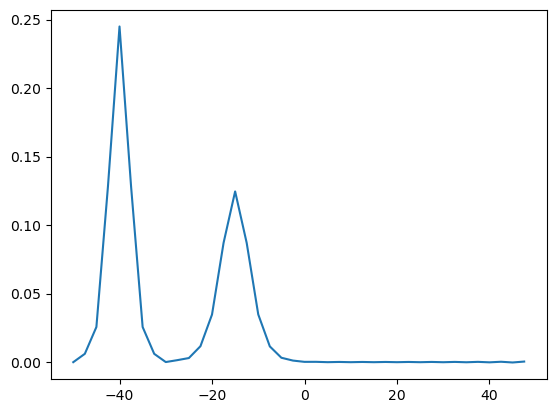

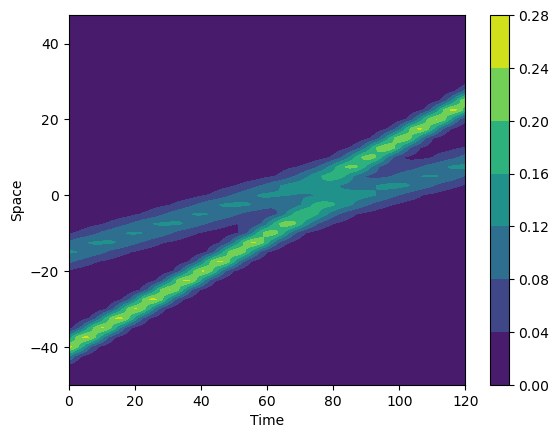

In [ ]:
N = 40
print(f"N={N}")
alpha = 0.9
t0 = 0
tf = 120
x1 = -50
x2 = 50
L = x2-x1
xx = np.arange(-L/2,L/2,L/N)
print(f"x values: {xx}")
print("")

x01 = -40
x02 = -15
c1 = 0.5
c2 = 0.25

def RHS(t,u):
    w = Dealias_orzag(u,fft_diff(u,N,x2-x1))
    return -(6*w+fft_diff(fft_diff(fft_diff(u,N,x2-x1),N,x2-x1),N,x2-x1))

def Dealias_IC_1(IC):
    N = len(IC)
    thres = N//2
    IChat = np.fft.fft(IC)
    # truncation
    IChat[thres:-thres] = 0
    return np.fft.ifft(IChat).real

def Dealias_IC_fine(IC,N):
    MM = len(IC)
    uuhat0 = np.fft.fft(IC) / MM  # normalization
    uuhat0 = np.fft.fftshift(uuhat0)  # reorder
    idx = np.round((MM - 1) / 2 + np.arange(-(N - 1) / 2, (N - 1) / 2 + 1)).astype(int) + np.mod(MM, 2)
    uu1 = np.fft.ifft(np.fft.ifftshift(uuhat0[idx]) * N)
    return uu1

def max_step(alpha,N,c):
    return alpha*1.73/((N**3/8)-3*N*0.5*c)

# m = 6
# u1 = true_u(xx[:m],t=t0,c=c1,x0=np.ones(m)*x01)
# u2 = true_u(xx[m:N],t=t0,c=c2,x0=np.ones(N-m)*x02)
# y0 = Dealias_IC_1(np.concatenate((u1,u2)))
N_fine = 500
m = 100
xx_fine = [j*x2*2/N_fine+x1 for j in range (N_fine)]
u1 = true_u(xx_fine[:m],t=t0,c=c1,x0=np.ones(m)*x01)
u2 = true_u(xx_fine[m:N_fine],t=t0,c=c2,x0=np.ones(N_fine-m)*x02)
y0 = Dealias_IC_fine(np.concatenate((u1,u2)),N)
plt.plot(xx,y0)
MAX_step = max_step(alpha=alpha,N=N,c=np.maximum(c1,c2))
print(f"Max time step used in RK3: {MAX_step}")
sol = solve_ivp(RHS,t_span=[t0,tf],y0=y0,method="RK23",max_step=MAX_step)
times = sol.t
print(f"number of time steps: {len(times)}")
uhat = sol.y
plt.figure()
T, X = np.meshgrid(times, xx)
contour = plt.contourf(T, X, uhat)
plt.colorbar(contour)
plt.xlabel('Time')
plt.ylabel('Space')
plt.show()

g) - timing

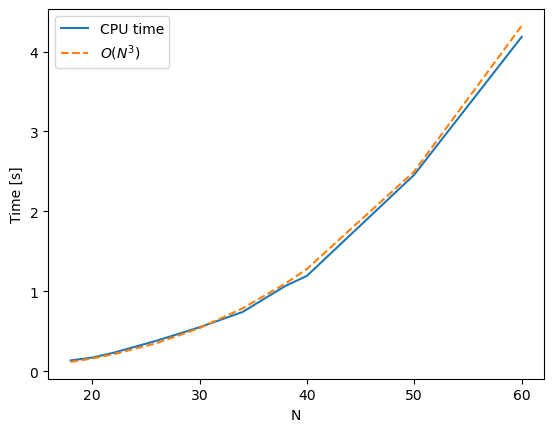

In [792]:
from timeit import default_timer as timer

def true_u(x,t,c,x0):
    return 1/2*c*sech_squared(1/2*np.sqrt(c)*(x-c*t-x0))
true_u = np.vectorize(true_u)

Ns = [18,20,22,26,30,34,38,40,50,60]
tf = 1
c = 0.1
alpha = 0.9
t0 = 0
tf = 0.5
x1 = -8*np.pi
x2 = 8*np.pi
L = x2-x1
def Dealias_IC(IC):
    N = len(IC)
    thres = N//3
    IChat = np.fft.fft(IC)
    # truncation
    IChat[thres:-thres] = 0
    return np.fft.ifft(IChat).real
def RHS(t,u):
    w = Dealias_orzag(u,fft_diff(u,N,x2-x1))
    return -(6*w+fft_diff(fft_diff(fft_diff(u,N,x2-x1),N,x2-x1),N,x2-x1))
x0 = np.zeros(N)
timing = []
for N in Ns:
    xx = np.arange(-L/2,L/2,L/N)
    x0 = np.zeros(N)
    true_sol = true_u(xx,t=tf,c=c,x0=x0)
    y0 = Dealias_IC_1(true_u(xx,t=t0,c=c,x0=x0))
    alpha = 0.99
    MAX_step = max_step(alpha=alpha,N=N,c=c)
    t1 = timer()
    sol = solve_ivp(RHS,t_span=[t0,tf],y0=y0,method="RK23",max_step=MAX_step)
    t2 = timer()
    times = sol.t
    uhat = sol.y
    error = np.max(uhat[:,-1]-true_sol)
    timing.append((t2-t1))#/len(times))

plt.figure()
plt.plot(Ns, timing,label="CPU time")
plt.ylabel("Time [s]")
plt.xlabel("N")
cubed = lambda x: x**3*10**(-5)*2
cubed = np.vectorize(cubed)
plt.plot(Ns,cubed(Ns),'--',label=r'$O(N^3)$')
plt.legend()